
# Tema 8 – Predicción de compradores recurrentes (Online Retail – *Auto*)
**Curso:** CC3084 – Data Science (Sem II 2025)  
**Equipo:** _Mauricio Lemus - 22461, Alexis Mesias - 22562, Hugo Rivas - 22500_  
**Repositorio GitHub:** _[https://github.com/Riv2oo4/Proyecto2_DataScience.git]_  


## 0) Preparación del entorno 

In [1]:

import os, sys, io, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
pd.set_option("display.max_columns", 120)
warnings.filterwarnings("ignore")

def in_colab():
    try:
        import google.colab  
        return True
    except Exception:
        return False

def kaggle_token_present():
    return os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")) or os.path.exists("./kaggle.json")

print("Entorno Colab:", in_colab())
print("kaggle.json presente:", kaggle_token_present())


Entorno Colab: False
kaggle.json presente: False


## 1) Descargar dataset Online Retail 

In [2]:

DATA_DIR = "./data"
os.makedirs(DATA_DIR, exist_ok=True)
DATA_PATH = os.path.join(DATA_DIR, "Online Retail.xlsx")

def try_kaggle_download():
    try:
        import subprocess, shutil, json, os
        if os.path.exists("./kaggle.json"):
            os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
            shutil.copyfile("./kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
            os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

        try:
            import kaggle  
        except Exception:
            subprocess.run([sys.executable, "-m", "pip", "install", "kaggle", "--quiet"], check=True)

        # Descargar y descomprimir
        zip_path = os.path.join(DATA_DIR, "onlineretail.zip")
        subprocess.run(["kaggle", "datasets", "download", "-d", "vijayuv/onlineretail", "-p", DATA_DIR, "--force"], check=True)
        subprocess.run(["unzip", "-o", zip_path, "-d", DATA_DIR], check=True)
        print("Descarga Kaggle completa.")
        return True
    except Exception as e:
        print("Kaggle no disponible o fallo descarga:", e)
        return False

if not os.path.exists(DATA_PATH) and kaggle_token_present():
    _ = try_kaggle_download()

print("DATA_PATH existe:", os.path.exists(DATA_PATH), "->", DATA_PATH if os.path.exists(DATA_PATH) else "No encontrado")


DATA_PATH existe: False -> No encontrado


## 2) Subir archivo manualmente 

In [3]:

if not os.path.exists(DATA_PATH):
    if in_colab():
        try:
            from google.colab import files  # type: ignore
            print("Sube el archivo Excel del dataset (e.g., 'Online Retail.xlsx').")
            uploaded = files.upload()
            # Guardar con nombre estándar si el usuario sube algo
            for name, data in uploaded.items():
                with open(DATA_PATH, "wb") as f:
                    f.write(data)
            print("Archivo guardado en:", DATA_PATH)
        except Exception as e:
            print("Subida manual no disponible:", e)
    else:
        print("No estás en Colab. Puedes colocar el Excel en ./data con nombre 'Online Retail.xlsx'.")


No estás en Colab. Puedes colocar el Excel en ./data con nombre 'Online Retail.xlsx'.


## 3) Cargar datos (o crear sintético si no hay archivo)

In [4]:

import pandas as pd, numpy as np

df = None
if os.path.exists(DATA_PATH):
    try:
        df = pd.read_excel(DATA_PATH)
        print("Cargado Excel:", DATA_PATH, "->", df.shape)
    except Exception as e:
        print("Error al leer Excel, se usará dataset sintético:", e)

if df is None:
    # ---- Synthetic fallback (guaranteed to run) ----
    print("Usando dataset sintético para ejecutar el flujo completo.")
    rng = np.random.default_rng(42)
    n_customers = 1500
    start = pd.Timestamp("2024-01-01")
    end = pd.Timestamp("2025-08-31")
    days = (end - start).days + 1

    customers = pd.DataFrame({
        "CustomerID": np.arange(1, n_customers+1),
        "Channel": rng.choice(["web","app","marketplace"], size=n_customers, p=[0.5,0.4,0.1]),
        "Device": rng.choice(["mobile","desktop","tablet"], size=n_customers, p=[0.6,0.35,0.05]),
    })

    orders_per_cust = rng.poisson(lam=1.6, size=n_customers) + (rng.random(n_customers) < 0.25)
    orders_per_cust = orders_per_cust.astype(int)
    orders_per_cust[orders_per_cust<1] = 1

    rows = []
    order_id = 1
    for cid, k in zip(customers["CustomerID"].values, orders_per_cust):
        for _ in range(k):
            d = start + pd.to_timedelta(rng.integers(0, days), unit="D")
            qty = int(max(1, rng.poisson(2)))
            price = float(max(1.0, np.round(rng.gamma(shape=2.2, scale=5.0), 2)))
            rows.append([str(order_id), str(cid), d, qty, price])
            order_id += 1

    df = pd.DataFrame(rows, columns=["InvoiceNo","CustomerID","InvoiceDate","Quantity","UnitPrice"])
    print("Sintético generado:", df.shape)

# Renombrar columnas a snake_case y crear 'amount'
rename_map = {
    "InvoiceNo": "invoice_no",
    "StockCode": "stock_code",
    "Description": "description",
    "Quantity": "quantity",
    "InvoiceDate": "invoice_date",
    "UnitPrice": "unit_price",
    "CustomerID": "customer_id",
    "Country": "country",
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

df["invoice_date"] = pd.to_datetime(df["invoice_date"], errors="coerce")
df["quantity"] = pd.to_numeric(df["quantity"], errors="coerce")
df["unit_price"] = pd.to_numeric(df["unit_price"], errors="coerce")
df["customer_id"] = pd.to_numeric(df["customer_id"], errors="coerce")
df["amount"] = df.get("quantity", 1) * df.get("unit_price", 1.0)

print("Preview:")
display(df.head(5))
print(df.dtypes)


Usando dataset sintético para ejecutar el flujo completo.
Sintético generado: (2889, 5)
Preview:


,invoice_no,customer_id,invoice_date,quantity,unit_price,amount
0,1,1,2024-12-18,1,6.85,6.85
1,2,1,2024-03-05,3,10.03,30.09
2,3,2,2025-04-27,2,27.51,55.02
3,4,3,2024-09-09,1,21.77,21.77
4,5,3,2025-05-22,5,6.23,31.15


invoice_no              object
customer_id              int64
invoice_date    datetime64[ns]
quantity                 int64
unit_price             float64
amount                 float64
dtype: object


## 4) Chequeos iniciales

In [5]:

print("Nulos por columna:")
print(df.isna().sum())

if "invoice_date" in df.columns:
    print("\nRango de fechas:")
    print(df["invoice_date"].min(), "->", df["invoice_date"].max())

if "amount" in df.columns:
    print("\n'amount' describe:")
    print(df["amount"].describe())


Nulos por columna:
invoice_no      0
customer_id     0
invoice_date    0
quantity        0
unit_price      0
amount          0
dtype: int64

Rango de fechas:
2024-01-01 00:00:00 -> 2025-08-31 00:00:00

'amount' describe:
count    2889.000000
mean       23.696521
std        23.947118
min         1.000000
25%         8.260000
50%        16.120000
75%        30.300000
max       280.000000
Name: amount, dtype: float64


## 5) Limpieza básica y agregación por orden

In [6]:

data = df.copy()

# Filtrar notas de crédito si existen (InvoiceNo que empieza con 'C')
if "invoice_no" in data.columns:
    mask_credit = data["invoice_no"].astype(str).str.startswith("C", na=False)
    data = data[~mask_credit].copy()

# Filtrar cantidades y precios válidos
for col in ["quantity","unit_price","customer_id","invoice_date"]:
    if col in data.columns:
        pass
data = data[(data.get("quantity", 1) > 0) & (data.get("unit_price", 1.0) > 0)]
data = data.dropna(subset=["customer_id","invoice_date"])

# Definir order_id y agrupar
data["order_id"] = data.get("invoice_no", data.index.astype(str))
orders = (
    data.groupby(["order_id", "customer_id", "invoice_date"], as_index=False)
        .agg(amount=("amount","sum"))
)
print("Órdenes únicas:", len(orders))
display(orders.head(5))


Órdenes únicas: 2889


,order_id,customer_id,invoice_date,amount
0,1,1,2024-12-18,6.85
1,10,6,2024-10-16,29.52
2,100,52,2025-08-05,21.26
3,1000,514,2025-02-05,48.15
4,1001,515,2025-06-13,33.04


# Parte 2 Resultados Iniciales

In [7]:
import numpy as np, pandas as pd
from datetime import timedelta

# Usamos las órdenes ya agregadas en la parte anterior
orders = orders.copy()
orders['invoice_date'] = pd.to_datetime(orders['invoice_date'])

# Horizonte de predicción (días hacia adelante para ver si recompra)
HORIZON_DAYS = 180

max_date = orders['invoice_date'].max()
test_ref  = max_date - pd.Timedelta(days=HORIZON_DAYS)
train_ref = test_ref - pd.Timedelta(days=HORIZON_DAYS)

def make_features(trans, ref_date):
    """
    Construye variables RFM + IPD + cohorte por cliente, 
    usando solo el historial hasta ref_date.
    """
    hist = trans[trans['invoice_date'] <= ref_date].copy()

    # R (recency), F (frequency), M (monetario)
    last_dt  = hist.groupby('customer_id')['invoice_date'].max()
    recency  = (ref_date - last_dt).dt.days.rename('recency_days')
    freq     = hist.groupby('customer_id').size().rename('frequency')
    mon_sum  = hist.groupby('customer_id')['amount'].sum().rename('monetary_sum')
    mon_avg  = hist.groupby('customer_id')['amount'].mean().rename('monetary_avg')

    # IPD (interpurchase days) – media, desviación, mediana
    def ipd_stats(g):
        d = g.sort_values('invoice_date')['invoice_date'].diff().dropna().dt.days
        return pd.Series({
            'ipd_mean': d.mean()   if len(d) else np.nan,
            'ipd_std' : d.std()    if len(d) else np.nan,
            'ipd_med' : d.median() if len(d) else np.nan
        })

    ipd = hist.groupby('customer_id').apply(ipd_stats)

    # Cohorte: mes de primera compra
    first_dt   = hist.groupby('customer_id')['invoice_date'].min()
    coh_month  = first_dt.dt.to_period('M').astype(str).rename('cohort_month')

    # Unimos todo
    feats = pd.concat([recency, freq, mon_sum, mon_avg, ipd, coh_month], axis=1).reset_index()

    # Rellenar faltantes razonables
    for c in ['ipd_mean', 'ipd_std', 'ipd_med']:
        feats[c] = feats[c].fillna(feats['recency_days'])
    feats = feats.fillna({
        'monetary_sum': 0.0,
        'monetary_avg': 0.0,
        'frequency': 0,
        'recency_days': (ref_date - trans['invoice_date'].min()).days
    })

    return feats

def make_labels(trans, ref_date, horizon_days=HORIZON_DAYS):
    """
    y = 1 si el cliente recompra en la ventana futura
    (ref_date, ref_date + horizon], 0 en caso contrario.
    """
    future = trans[
        (trans['invoice_date'] > ref_date) &
        (trans['invoice_date'] <= ref_date + pd.Timedelta(days=horizon_days))
    ]
    y1 = pd.Series(1, index=future['customer_id'].unique(), name='y').to_frame()
    y1.index.name = 'customer_id'
    return y1.reset_index()

def build_dataset(trans, ref_date, horizon_days=HORIZON_DAYS):
    X = make_features(trans, ref_date)
    y = make_labels(trans, ref_date, horizon_days)
    data = X.merge(y, how='left', on='customer_id')
    data['y'] = data['y'].fillna(0).astype(int)
    return data

# Datasets de entrenamiento y prueba (split temporal)
train_df = build_dataset(orders, train_ref, HORIZON_DAYS)
test_df  = build_dataset(orders, test_ref,  HORIZON_DAYS)

print("Train:", train_df.shape, "Test:", test_df.shape)
train_df.head()


Train: (891, 10) Test: (1256, 10)


,customer_id,recency_days,frequency,monetary_sum,monetary_avg,ipd_mean,ipd_std,ipd_med,cohort_month,y
0,1,184,1,30.09,30.09,184.0,184.0,184.0,2024-03,1
1,4,176,1,13.55,13.55,176.0,176.0,176.0,2024-03,0
2,5,62,1,64.71,64.71,62.0,62.0,62.0,2024-07,0
3,7,0,1,12.99,12.99,0.0,0.0,0.0,2024-09,0
4,11,82,1,16.23,16.23,82.0,82.0,82.0,2024-06,0


In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, brier_score_loss

# Columnas numéricas y categóricas
num_cols = ['recency_days','frequency','monetary_sum','monetary_avg',
            'ipd_mean','ipd_std','ipd_med']
cat_cols = ['cohort_month']

train_df['cohort_month'] = train_df['cohort_month'].astype(str).fillna('NA')
test_df['cohort_month']  = test_df['cohort_month'].astype(str).fillna('NA')

X_train = train_df[num_cols + cat_cols].copy()
y_train = train_df['y'].astype(int).values
X_test  = test_df[num_cols + cat_cols].copy()
y_test  = test_df['y'].astype(int).values

# Preprocesamiento: imputar y one-hot
pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median"))
        ]), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols),
    ],
    remainder="drop"
)


## Regresión Logística

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

logit = Pipeline(steps=[
    ("pre", pre),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

# Calibrar probabilidades
logit_cal = CalibratedClassifierCV(logit, method="isotonic", cv=3)
logit_cal.fit(X_train, y_train)

# Probabilidades de recompra
p_logit = logit_cal.predict_proba(X_test)[:, 1]

res_logit = {
    "model": "Logistic+Cal",
    "roc_auc": roc_auc_score(y_test, p_logit),
    "pr_auc":  average_precision_score(y_test, p_logit),
    "brier":   brier_score_loss(y_test, p_logit)
}
res_logit


{'model': 'Logistic+Cal',
 'roc_auc': 0.5260365167581574,
 'pr_auc': 0.3496300299027636,
 'brier': 0.2283826803019739}

#LightGBM

In [10]:
!pip -q install lightgbm



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\Alexis Mesias\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [11]:
import lightgbm as lgb

# Ajustar el preprocesador una vez
pre_fitted = pre.fit(X_train, y_train)
Xtr = pre_fitted.transform(X_train)
Xte = pre_fitted.transform(X_test)

clf_lgb = lgb.LGBMClassifier(
    objective="binary",
    n_estimators=10000,          # muchos árboles + early stopping
    learning_rate=0.05,
    num_leaves=63,
    min_data_in_leaf=100,
    feature_fraction=0.8,
    subsample=0.9,
    subsample_freq=1,
    n_jobs=-1
)

clf_lgb.fit(
    Xtr, y_train,
    eval_set=[(Xte, y_test)],
    eval_metric="auc",
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(0)
    ]
)

p_lgbm = clf_lgb.predict_proba(Xte)[:, 1]

res_lgbm = {
    "model": "LightGBM",
    "best_iter": int(getattr(clf_lgb, "best_iteration_", clf_lgb.n_estimators)),
    "roc_auc": float(roc_auc_score(y_test, p_lgbm)),
    "pr_auc":  float(average_precision_score(y_test, p_lgbm)),
    "brier":   float(brier_score_loss(y_test, p_lgbm)),
}
res_lgbm


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Number of positive: 324, number of negative: 567
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1427
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 12
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] featu

{'model': 'LightGBM',
 'best_iter': 2,
 'roc_auc': 0.5138031754691034,
 'pr_auc': 0.3468022624157348,
 'brier': 0.22381415852810818}

# CatBoost

In [12]:
!pip -q install catboost



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\Alexis Mesias\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [13]:
from catboost import CatBoostClassifier

X_train_cb = train_df[num_cols + cat_cols].copy()
X_test_cb  = test_df[num_cols + cat_cols].copy()

for c in cat_cols:
    X_train_cb[c] = X_train_cb[c].astype('category').cat.add_categories(['NA']).fillna('NA')
    X_test_cb[c]  = X_test_cb[c].astype('category').cat.add_categories(['NA']).fillna('NA')

y_train_cb = train_df['y'].astype(int).values
y_test_cb  = test_df['y'].astype(int).values

cat_idx = [X_train_cb.columns.get_loc(c) for c in cat_cols]

cb = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    learning_rate=0.05,
    depth=6,
    iterations=500,
    random_seed=42,
    verbose=False
)

cb.fit(
    X_train_cb, y_train_cb,
    eval_set=(X_test_cb, y_test_cb),
    cat_features=cat_idx
)

p_cb = cb.predict_proba(X_test_cb)[:, 1]

res_cb = {
    "model": "CatBoost",
    "roc_auc": roc_auc_score(y_test_cb, p_cb),
    "pr_auc":  average_precision_score(y_test_cb, p_cb),
    "brier":   brier_score_loss(y_test_cb, p_cb)
}
res_cb


{'model': 'CatBoost',
 'roc_auc': 0.5312702444679327,
 'pr_auc': 0.3724490268028136,
 'brier': 0.24675608082977912}

In [14]:
import pandas as pd
from sklearn.metrics import f1_score

# Predicciones binarias con umbral 0.5
y_pred_logit = (p_logit >= 0.5).astype(int)
y_pred_lgbm  = (p_lgbm >= 0.5).astype(int)
y_pred_cb    = (p_cb   >= 0.5).astype(int)

results = pd.DataFrame([
    {
        "model": res_logit["model"],
        "roc_auc": res_logit["roc_auc"],
        "pr_auc":  res_logit["pr_auc"],
        "brier":   res_logit["brier"],
        "f1":      f1_score(y_test, y_pred_logit)
    },
    {
        "model": res_lgbm["model"],
        "roc_auc": res_lgbm["roc_auc"],
        "pr_auc":  res_lgbm["pr_auc"],
        "brier":   res_lgbm["brier"],
        "f1":      f1_score(y_test, y_pred_lgbm)
    },
    {
        "model": res_cb["model"],
        "roc_auc": res_cb["roc_auc"],
        "pr_auc":  res_cb["pr_auc"],
        "brier":   res_cb["brier"],
        "f1":      f1_score(y_test_cb, y_pred_cb)
    },
])

results.sort_values(by="pr_auc", ascending=False).reset_index(drop=True)


,model,roc_auc,pr_auc,brier,f1
0,CatBoost,0.531270,0.372449,0.246756,0.212996
1,Logistic+Cal,0.526037,0.349630,0.228383,0.098361
2,LightGBM,0.513803,0.346802,0.223814,0.000000


In [ ]:
import pandas as pd

display(results)

res = results.copy()
res["model"] = res["model"].astype(str)
res = res.set_index("model")
display(res)


,model,roc_auc,pr_auc,brier,f1
0,Logistic+Cal,0.526037,0.349630,0.228383,0.098361
1,LightGBM,0.513803,0.346802,0.223814,0.000000
2,CatBoost,0.531270,0.372449,0.246756,0.212996


,roc_auc,pr_auc,brier,f1
model,,,,
Logistic+Cal,0.526037,0.349630,0.228383,0.098361
LightGBM,0.513803,0.346802,0.223814,0.000000
CatBoost,0.531270,0.372449,0.246756,0.212996


In [22]:
import os
import matplotlib.pyplot as plt

os.makedirs("plots", exist_ok=True)

def plot_metric_bars(df, metric, lower_is_better=False, filename=None, title=None, fmt="{:.3f}"):
    series = df[metric].dropna()
    if series.empty:
        print(f"No hay datos para la métrica '{metric}'.")
        return
    
    # Orden: descendente si más alto es mejor; ascendente si más bajo es mejor
    series = series.sort_values(ascending=lower_is_better)
    
    plt.figure()
    ax = series.plot(kind="bar")
    ax.set_title(title or f"Comparación por modelo: {metric.upper()}")
    ax.set_ylabel(metric)
    ax.set_xlabel("Modelo")
    plt.xticks(rotation=45, ha="right")
    
    # Etiquetas de valo
    for p in ax.patches:
        value = p.get_height()
        ax.annotate(fmt.format(value), 
                    (p.get_x() + p.get_width()/2, value),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=9)
    
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=160, bbox_inches="tight")
    plt.show()


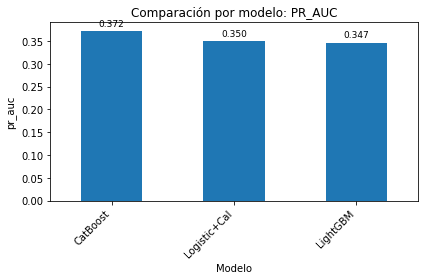

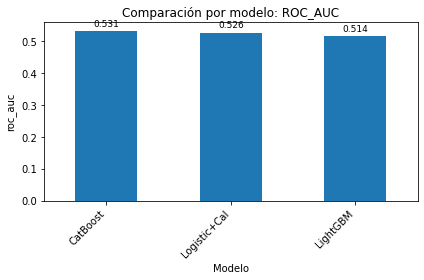

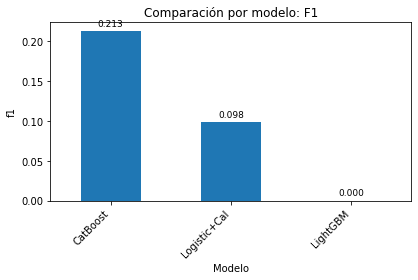

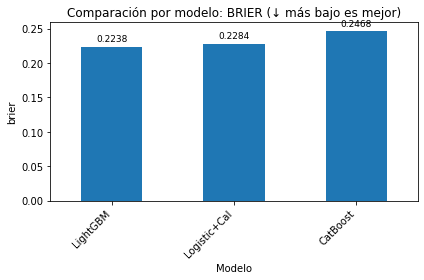

In [23]:
# Métricas donde más alto es mejor
for metric in ["pr_auc", "roc_auc", "f1"]:
    if metric in res.columns:
        plot_metric_bars(
            res, 
            metric, 
            lower_is_better=False, 
            filename=f"plots/{metric}_by_model.png", 
            title=f"Comparación por modelo: {metric.upper()}",
            fmt="{:.3f}"
        )

# Métricas donde más bajo es mejor (ej. Brier)
if "brier" in res.columns:
    plot_metric_bars(
        res, 
        "brier", 
        lower_is_better=True, 
        filename="plots/brier_by_model.png", 
        title="Comparación por modelo: BRIER (↓ más bajo es mejor)",
        fmt="{:.4f}"
    )
